In [1]:
from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

Traffic dataset.

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/denoised_v3.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    init_features=["latitude", "longitude"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 17914
    File location: ../deep_traffic_generation/data/denoised_v3.pkl
    MinMaxScaler(feature_range=(-1, 1))

Model.

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_2/checkpoints/epoch=193-step=2327.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_2/hparams.yaml",
    input_dim = dataset.input_dim,
    seq_len = dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [74]:
x, y, info = dataset[500]
x = x.unsqueeze(0)
z, x_hat = model(x)

In [75]:
x.size()

torch.Size([1, 4, 200])

In [76]:
x_hat.size()

torch.Size([1, 4, 200])

In [77]:
z.size()

torch.Size([1, 64])

In [78]:
x = torch.transpose(x, 1, 2)
x_hat = torch.transpose(x_hat, 1, 2)

In [79]:
data = np.concatenate((x.numpy(), x_hat.detach().numpy()))
data.shape

(2, 200, 4)

In [80]:
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [81]:
info = np.repeat(info.unsqueeze(0), data.shape[0], axis=0)
data = np.concatenate((info, data), axis=1)
data.shape

(2, 802)

In [82]:
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

(2, 800)


,count
flight_id,
0,200
1,200


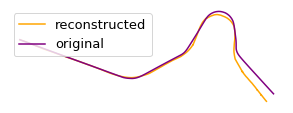

In [83]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, figsize=(5, 5), subplot_kw=dict(projection=EuroPP())
    )
    traffic[1].plot(ax, c="orange", label="reconstructed")
    traffic[0].plot(ax, c="purple", label="original")
    ax.legend()

In [84]:
traffic[0].chart("altitude").encode()

alt.Chart(...)

In [85]:
traffic[1].chart("altitude").encode()

alt.Chart(...)

In [86]:
traffic[0].chart("groundspeed").encode()

alt.Chart(...)

In [87]:
traffic[1].chart("groundspeed").encode()

alt.Chart(...)